In [254]:
%matplotlib inline

import imageio
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

## FUNCTIONS

In [2]:
def readVideoFrames(filename):
    vid = imageio.get_reader(filename,  'ffmpeg')
    fps = vid.get_meta_data()['fps']
    num = 0
    frames = []
    while 1:
        try:
            image = vid.get_data(num)
            frames.append(image)
            num+=1
        except IndexError:
            break

    return np.array(frames), fps

In [3]:
def makeGrayScale(rgbVid):
    '''Converts numpy array vid to grayscale vid'''
    frames_bw = []
    for frame in rgbVid:
        frames_bw.append(np.around(np.dot(frame[:,:,:3], [0.2989, 0.587, 0.114])))
    return np.array(frames_bw)

In [4]:
def calculateDifferenceFrames(frames):
    dif_lst = []
    for i in range(1, frames.shape[0]):
        dif_lst.append(frames[i-1,:,:]-frames[i,:,:])
    return np.array(dif_lst)

In [5]:
def divideToMacroblocks(frame, macroblock_size=16):
    macroblocks = []
    m, n = frame.shape
    for i in range(0, m, macroblock_size):
        for j in range(0, n, macroblock_size):
            macroblock = frame[i:i+macroblock_size,j:j+macroblock_size]
    #         print (macroblock.shape)
            if macroblock.shape == (macroblock_size, macroblock_size):
    #             print ('works')
                macroblocks.append(macroblock)
            else:
    #             print ('something\'s goin\' on')
                try:
                    macroblock = np.vstack((macroblock, np.zeros(macroblock.shape[0], macroblock_size-macroblock.shape[1])))
                except TypeError:
                    pass
                try:
                    macroblock = np.hstack((macroblock, np.zeros(macroblock_size-macroblock.shape[0], macroblock.shape[1])))
                except TypeError:
                    pass
                macroblocks.append(macroblock)
    return np.array(macroblocks).reshape((int(m/macroblock_size), int(n/macroblock_size), macroblock_size, macroblock_size))

In [6]:
def createNeighborhood(referenceFrame, indexOfMacroblock, macroblock_size=16, k=16):
    neighborhood = []
#     print (indexOfMacroblock)
    for i in range(indexOfMacroblock[0]-k, indexOfMacroblock[0]+k+1, k):
        for j in range(indexOfMacroblock[1]-k, indexOfMacroblock[1]+k+1, k):
            if (i >= 0 and j >= 0 and i+macroblock_size < referenceFrame.shape[0] and j+macroblock_size < referenceFrame.shape[1]):
#                 print (i,j)
                neighborhood.append(referenceFrame[i:i+macroblock_size, j:j+macroblock_size])
            else:
                neighborhood += [None]
    return neighborhood

In [7]:
def SAD(referenceMacroblock, targetMacroblock):
#     print (targetMacroblock.shape, referenceMacroblock.shape)
    return np.sum(np.abs(targetMacroblock - referenceMacroblock))

In [8]:
def calculateSAD(targetMacroblock, referenceFrame_neighbor_macroblocks):
    SADvals = []
        
    for macroblock in referenceFrame_neighbor_macroblocks:
        if macroblock is not None:
            SADvals.append(SAD(macroblock, targetMacroblock))
        else:
            SADvals.append(np.Inf)
    
    return np.array(SADvals).reshape((3,3))

In [9]:
def logarithmicSearch(referenceFrame, targetMacroblock, indexOfMacroblock, macroblock_size=16, k=16):
    if (k == 0):
        return indexOfMacroblock, referenceFrame[indexOfMacroblock[0]:indexOfMacroblock[0]+macroblock_size, indexOfMacroblock[1]:indexOfMacroblock[1]+macroblock_size] # motionVector END (To_WIDTH, To_HEIGHT), return Predicted Frame
    
    referenceFrame_neighbor_macroblocks = createNeighborhood(referenceFrame, indexOfMacroblock, macroblock_size, k)

    SAD_values = calculateSAD(targetMacroblock, referenceFrame_neighbor_macroblocks)
#     print (SAD_values)
    indexofMinimumSAD = divmod(SAD_values.argmin(), SAD_values.shape[1])
    newIndexOfMacroblock = list(indexOfMacroblock)
    
    if (indexofMinimumSAD[0] == 0):
        newIndexOfMacroblock[0] = indexOfMacroblock[0] - k
    elif (indexofMinimumSAD[0] == 2):
        newIndexOfMacroblock[0] = indexOfMacroblock[0] + k
    
    if (indexofMinimumSAD[1] == 0):
        newIndexOfMacroblock[1] = indexOfMacroblock[1] - k
    elif (indexofMinimumSAD[1] == 2):
        newIndexOfMacroblock[1] = indexOfMacroblock[1] + k

    if (indexofMinimumSAD[0] == 1 and indexofMinimumSAD[1] == 1):
        newK = k//2
    else:
        newK = k       
#     print (indexofMinimumSAD)
#     print (newIndexOfMacroblock)
    return logarithmicSearch(referenceFrame, targetMacroblock, tuple(newIndexOfMacroblock), macroblock_size, newK)

In [10]:
def motionCompensation(referenceFrame, targetFrame, macroblock_size=16):
    predictedBlocks = []
    motionVectors = []
    
    targetMacroblocks = divideToMacroblocks(targetFrame, macroblock_size)
    for i in range(targetMacroblocks.shape[0]):
        for j in range(targetMacroblocks.shape[1]):
            motionVectorSTART = (i*macroblock_size, j*macroblock_size)
            indexofBlock = (i*macroblock_size, j*macroblock_size)
            motionVectorEND, prediction = logarithmicSearch(referenceFrame, targetMacroblocks[i,j,:,:], indexofBlock)
            predictedBlocks.append(prediction)
            motionVectors.append(motionVectorSTART+motionVectorEND)

#     print (len(motionVectors))
    predictedBlocks = np.array(predictedBlocks).reshape(targetMacroblocks.shape)
    motionVectors = np.array(motionVectors, dtype=(int,4)).reshape((targetMacroblocks.shape[0], targetMacroblocks.shape[1], 4))
    return predictedBlocks, motionVectors

In [13]:
def imageReconstructFromBlocks(blocks):
    lines = []
    for i in range(blocks.shape[0]):
        line = []
        for j in range(blocks.shape[1]):
            line.append(blocks[i,j,:,:])
        line = np.hstack(line)
        lines.append(line)
    return np.vstack(lines)

In [277]:
def find_moving_object(mbs): #V2 - the input arguments have changed!!!
    lst = make_var_list(mbs)
    X = np.array(lst)
    q25_75=np.array([])
    outliers_list_batch = []
    
    data = [i[0] for i in X]


    if not q25_75.any():
        q25_75 = np.zeros((X.shape[1],2))	#V3 - changed X.shape[0] to X.shape[1]
    for line in range(X.shape[1]):
    #     if line%300==0:
    #         print 'lines processed: ', line, ' out of ', X.shape[1]
        x = X[:,line].copy()        
        outliers_list = []

        if sum(abs(x))!=0:
            q25=q25_75[line,0]
            q75=q25_75[line,1]

            if (q25==0) & (q75==0):
                q75, q25 = np.percentile(x[x!=0], [75,25])

            iqr = q75 - q25
            outl = np.argwhere(abs(x)>q75+3*iqr)
            outliers = group_consecutives(outl)
            for ll in outliers:
                if ll:
                    current = int(ll[0][0]),int(ll[-1][0])
                    outliers_list.append(current)        
        else:
            outliers_list.append([])
            q75 = 0
            q25 = 0

        outliers_list_batch.append(outliers_list)
        q25_75[line,:] = [q25,q75]
        
    fn_lst = []
    for i in range(outliers_list_batch[0][0][0], outliers_list_batch[0][0][1]+1):
        fn_lst.append(tuple(lst[i][1:]))
    # print 'done.'
    return fn_lst

In [133]:
def group_consecutives(vals, step=1):
    """Return list of consecutive lists of numbers from vals (number list)."""
    run = []
    result = [run]
    expect = None
    for v in vals:
        if (v == expect) or (expect is None):
            run.append(v)
        else:
            run = [v]
            result.append(run)
        expect = v + step
    return result

In [253]:
def make_var_list(mbs):
    lst = []
    for y, macby in enumerate(mbs):
        for x, macbx in enumerate(macby):
            lst.append((max(pd.DataFrame(macbx).var()), y, x))
            
    return lst

In [255]:
def swap_object(x_and_y, frame, back):
    for tup in x_and_y:
        y,x = tup
        frame[y][x] = back[y][x]
        
    return frame

In [264]:
def reconstruct_vid(img1, diffs):
    final_vid  = [img1]
    cnt = 1
    for frame in diffs:
        final_vid.append(final_vid[-1]-frame)
        
    
    return np.array(final_vid)

## Main

In [261]:
hall_monitor_cif = "resources/ex617/hall_monitor_cif.y4m"
resources_path = "resources/ex818"

In [17]:
videoFrames, fps = readVideoFrames(hall_monitor_cif)

In [18]:
videoFramesSample = videoFrames[:, :, :, :]
videoFramesSample.shape

(300, 288, 352, 3)

In [19]:
videoFramesSample = makeGrayScale(videoFramesSample)
videoFramesSample.shape

(300, 288, 352)

In [278]:
compensatedVideoFramesSample = [videoFramesSample[0]]
motionVectors = []
cnt = 1
for prevFrame, nextFrame in zip(videoFramesSample, videoFramesSample[1:]):
    
    prediction, vectors = motionCompensation(prevFrame, nextFrame)
    diff = compensatedVideoFramesSample[-1]-imageReconstructFromBlocks(prediction)
    
    mcbs = divideToMacroblocks(diff)
    npred = swap_object(find_moving_object(mcbs), prediction, compensatedVideoFramesSample[0])
    
    predFrame = imageReconstructFromBlocks(npred)
    compensatedVideoFramesSample.append(predFrame)
    motionVectors.append(vectors) 
    if cnt == 6:
        break
    else:
        cnt+=1
    

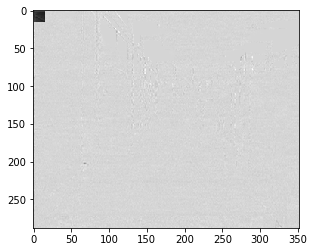

In [279]:
plt.imshow(diff, cmap= 'gray')

In [271]:
writer = imageio.get_writer(os.path.join(resources_path,'hall_monitor_cif_exafanizol2.mp4'), fps=fps,mode="I")

for frame in compensatedVideoFramesSample:
    writer.append_data(frame)
writer.close()

/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [0.0, 255.0]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


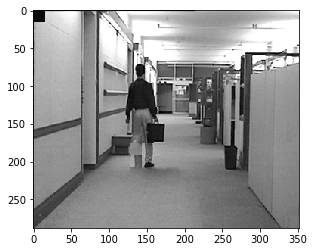

In [272]:
plt.imshow(compensatedVideoFramesSample[51], cmap='gray')

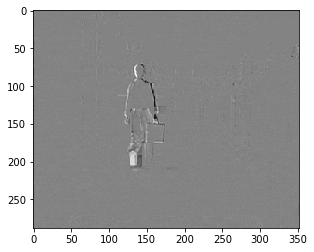

In [266]:
plt.imshow(compensatedVideoFramesSample[51]-compensatedVideoFramesSample[50], cmap='gray')

In [24]:
tmp = compensatedVideoFramesSample[50]-compensatedVideoFramesSample[51]

In [172]:
mc = divideToMacroblocks(tmp, 32)

In [173]:
mc.shape

(9, 11, 32, 32)

In [44]:
tmp.shape

(288, 352)

In [45]:
mc[0][0].shape

(32, 32)

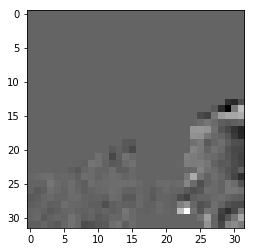

In [161]:
plt.imshow(mc[1][10], cmap='gray')

In [119]:
max(pd.DataFrame(mc[5][4]).max())

111.0

In [136]:
lst = []
for y, macby in enumerate(mc):
    for x, macbx in enumerate(macby):
        lst.append((max(pd.DataFrame(macbx).var()), y, x))

In [148]:
[i[0] for i in lst].sort()

In [150]:
lst.sort(key=lambda x: x[0])

In [158]:
lst[0][1:]

(0, 10)

In [151]:
lst

[(5.03125, 0, 10),
 (11.09274193548387, 0, 6),
 (11.544354838709678, 7, 5),
 (12.28125, 0, 4),
 (12.350806451612904, 0, 5),
 (13.047379032258064, 1, 7),
 (13.419354838709678, 1, 5),
 (13.80241935483871, 0, 8),
 (13.983870967741936, 0, 9),
 (14.17741935483871, 7, 4),
 (14.564516129032258, 3, 10),
 (14.963709677419354, 6, 10),
 (15.67741935483871, 1, 1),
 (15.789314516129032, 7, 6),
 (16.21673387096774, 7, 10),
 (16.46673387096774, 2, 10),
 (16.47983870967742, 7, 8),
 (16.482862903225808, 0, 7),
 (16.64516129032258, 7, 3),
 (16.83467741935484, 5, 6),
 (16.899193548387096, 8, 4),
 (17.016129032258064, 1, 6),
 (17.684475806451612, 6, 9),
 (17.869959677419356, 8, 6),
 (18.063508064516128, 8, 0),
 (18.06451612903226, 7, 2),
 (18.112903225806452, 7, 7),
 (18.555443548387096, 5, 9),
 (18.866935483870968, 6, 6),
 (18.899193548387096, 5, 10),
 (19.200604838709676, 4, 10),
 (20.931451612903224, 8, 8),
 (21.225806451612904, 8, 3),
 (21.684475806451612, 8, 2),
 (21.806451612903224, 7, 1),
 (22.0927

In [214]:
outs = outlier_detection(lst)

In [212]:
outlier_detection(lst)

[(1, 10),
 (3, 8),
 (5, 3),
 (5, 5),
 (4, 3),
 (4, 4),
 (3, 3),
 (5, 4),
 (3, 4),
 (4, 5),
 (6, 4),
 (2, 4),
 (3, 5)]

In [181]:
print(outs)

[(1.0, 10.0), (3.0, 8.0), (5.0, 3.0), (5.0, 5.0), (4.0, 3.0), (4.0, 4.0), (3.0, 3.0), (5.0, 4.0), (3.0, 4.0), (4.0, 5.0), (6.0, 4.0), (2.0, 4.0), (3.0, 5.0)]


In [234]:
for el in outs:
    y,x = el
    y,x 
    mc2[y][x]=mc[y][x]

In [230]:
new = np.zeros_like(tmp)

In [231]:
mc2 = divideToMacroblocks(new, 32)

In [232]:
mc2.shape

(9, 11, 32, 32)

In [249]:
for y, macby in enumerate(mc):
    for x, macbx in enumerate(macby):
        if (y,x) not in outs:
            mc2[y][x]=1000
        else:
            print ('y')
            mc2[y][x]=mc[y][x]

y
y
y
y
y
y
y
y
y
y
y
y
y


In [250]:
mc2[4][5]

array([[37.,  9., 64., ..., -2., -7., -2.],
       [43., 11., 59., ...,  1., -4.,  1.],
       [50., 21., 56., ...,  5.,  2., -1.],
       ...,
       [ 2., -3., -6., ...,  3.,  2.,  3.],
       [ 5., -3., -5., ...,  0.,  0.,  2.],
       [ 2.,  0., -1., ...,  0.,  2.,  4.]])

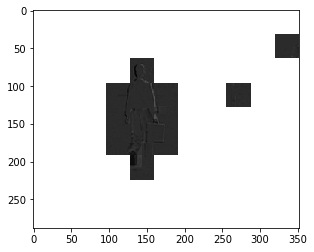

In [251]:
frame = imageReconstructFromBlocks(mc2)
plt.imshow(frame, cmap='gray')

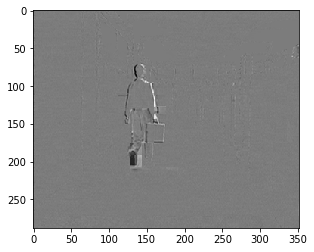

In [217]:
frame = imageReconstructFromBlocks(mc)
plt.imshow(frame, cmap='gray')